In [339]:
# Импорт библиотек
import pandas as pd
import numpy as np

from pymatgen.core.composition import Composition

from matplotlib import pyplot as plt
import seaborn as sns

In [340]:
# Загрузка датафрейма
df = pd.read_csv('task 3.csv')
df.head()

,formula,Km,Kcat,Syngony,length,width,depth,pol,surf,Subtype,ph,temp,Cper,Csub,Ccat
0,CoFe2O4,0.00645,12 306.45,7,4.1,4.1,4.1,1,1,TMB,4.0,37.0,100.0,15.0,0.02624
1,CoFe2O4,0.05537,2 363.29,7,13.8,13.8,13.8,1,1,TMB,4.0,37.0,100.0,15.0,0.02624
2,CoFe2O4,0.03551,74 779.37,7,4.1,4.1,4.1,1,1,TMB,4.0,37.0,100.0,15.0,0.02624
3,CoFe2O4,0.22769,3 918.25,7,13.8,13.8,13.8,1,1,TMB,4.0,37.0,100.0,15.0,0.02624
4,CoFe2O4,0.01725,9 184.91,7,24.5,24.5,24.5,1,1,H2O2,4.0,37.0,100.0,15.0,0.02624


In [341]:
# Исправление ошибок
df['Kcat'] = df['Kcat'].apply(
    lambda x: x.replace(' ', '')
).astype('float64')

In [343]:
# Вспомогательные функции

def num(df):
    return df.select_dtypes(include=np.number)

def show_num_cols(df):
    df_num = num(df)
    fig, ax_ = plt.subplots(3, 5, figsize=(12, 11))
    ax = []
    for i in ax_:
        ax += i.tolist()
    for i, col in enumerate(df_num.columns):
        sns.violinplot(data=df, x=col, ax=ax[i])
    plt.show()

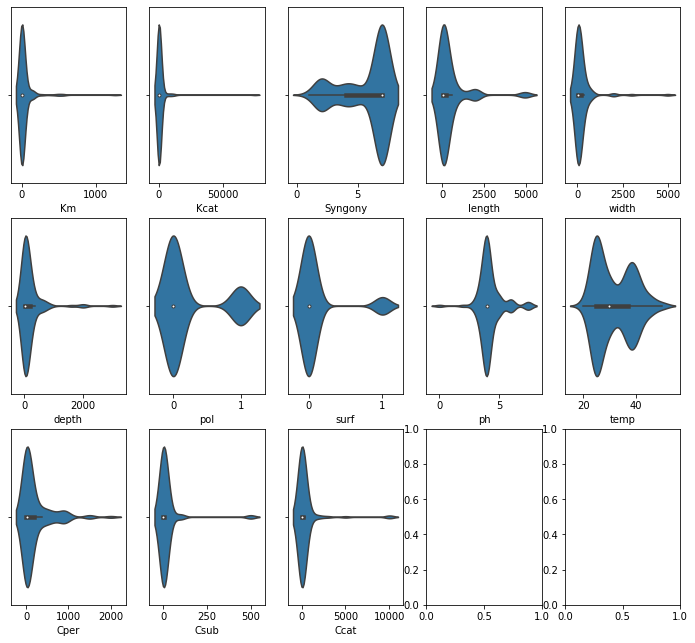

In [6]:
show_num_cols(df)

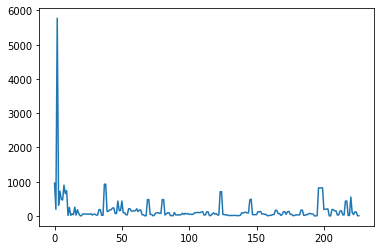

In [344]:
# Удаление выбросов

df_num = num(df)
pl = []

for row in df_num.iloc:
    pl.append(row.mean())

pl = np.array(pl)

plt.plot(pl)
plt.show()

In [345]:
ids = np.where(pl > 1500)[0]
ids

array([2], dtype=int64)

In [346]:
df.drop(ids, inplace=True)
df.reset_index(drop=True, inplace=True)

In [347]:
# Дополнительные параметры

# Объём
df['volume'] = df['length'] * df['width'] * df['depth']
# Площадь
df['surface'] = 2 * df['length'] * df['width'] + 2 * df['length'] * df['depth'] + 2 * df['width'] * df['depth']
# Удельная площадь. Она может влиять
# на параметры Kcat и Km, т.к. реакция идёт
# интенсивнее если удельная площадь большая.
df['u_surface'] = df['surface'] / df['volume']
# Максимальная скорость реакции. Поможет в
# предсказании целевых переменных
df['Vmax'] = df['Kcat'] * df['Ccat']

In [348]:
# Поиск электроотрицательности.
# От неё должен зависеть параметр Km.

electroneg = []
for formula in df['formula']:
    for splitter in ['/', '-', '–']:
        formula = formula.split(splitter)[-1]
    formula = formula.split(',')[0]
    comp = Composition(formula)
    electroneg.append(comp.average_electroneg)
df['electroneg'] = np.array(electroneg)

In [350]:
# Проверка на null-значения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   formula     226 non-null    object 
 1   Km          226 non-null    float64
 2   Kcat        226 non-null    float64
 3   Syngony     226 non-null    int64  
 4   length      226 non-null    float64
 5   width       226 non-null    float64
 6   depth       226 non-null    float64
 7   pol         226 non-null    int64  
 8   surf        226 non-null    int64  
 9   Subtype     226 non-null    object 
 10  ph          226 non-null    float64
 11  temp        226 non-null    float64
 12  Cper        226 non-null    float64
 13  Csub        226 non-null    float64
 14  Ccat        226 non-null    float64
 15  volume      226 non-null    float64
 16  surface     226 non-null    float64
 17  u_surface   226 non-null    float64
 18  Vmax        226 non-null    float64
 19  electroneg  226 non-null    f

In [351]:
# Столбец с формулами больше не нужен.
df.drop('formula', axis=1, inplace=True)

In [352]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

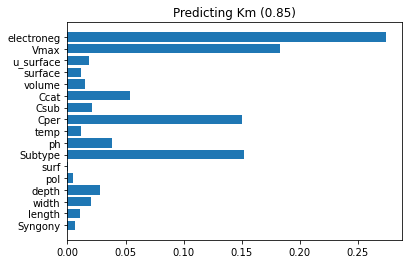

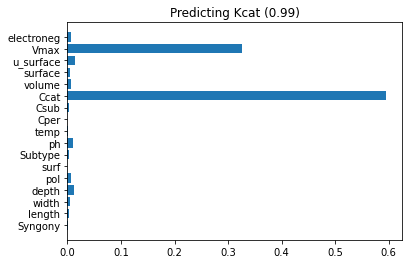

In [353]:
# Нахождение ненужных параметров

targets = ['Km', 'Kcat']
encoded = df.copy()

for col in encoded.columns:
    if encoded[col].dtype != 'object':
        continue
    encoded[col] = LabelEncoder().fit_transform(encoded[col])

for col in targets:
    x_train = encoded.drop(targets, axis=1)
    y_train = encoded[col]
    rfr = RandomForestRegressor(random_state=0).fit(x_train, y_train)
    score = rfr.score(x_train, y_train)
    feat_imp = rfr.feature_importances_
    plt.title(f'Predicting {col} ({round(score, 2)})')
    plt.barh(x_train.columns, feat_imp)
    plt.show()

<AxesSubplot:>

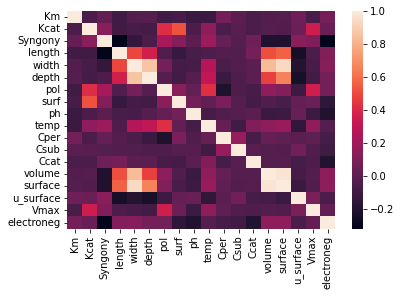

In [354]:
# Корреляционная матрица
sns.heatmap(df.corr())

In [355]:
# Удаление ненужных параметров
df.drop([
    'surface', 'width', 'surf', 'pol', 'Syngony', 'temp', 'Csub'
], axis=1, inplace=True)

In [356]:
# Скейлинг данных
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scalers = dict([
    (col, MinMaxScaler().fit(
        encoded[col].values.reshape(-1, 1)
    )) for col in encoded.columns
])

In [357]:
scaled = encoded.copy()

for col in scaled.columns:
    scaled[col] = scalers[col].transform(
        scaled[col].values.reshape(-1, 1)
    )

scaled.head()

,Km,Kcat,Syngony,length,width,depth,pol,surf,Subtype,ph,temp,Cper,Csub,Ccat,volume,surface,u_surface,Vmax,electroneg
0,0.000005,1.000000,1.0,0.000554,0.000554,0.000924,1.0,1.0,0.750,0.533333,0.566667,0.05,0.03,0.000002,1.664209e-09,0.000001,0.324083,0.195820,0.645616
1,0.000044,0.192037,1.0,0.002495,0.002495,0.004159,1.0,1.0,0.750,0.533333,0.566667,0.05,0.03,0.000002,6.564298e-08,0.000014,0.095966,0.037605,0.645616
2,0.000180,0.318390,1.0,0.002495,0.002495,0.004159,1.0,1.0,0.750,0.533333,0.566667,0.05,0.03,0.000002,6.564298e-08,0.000014,0.095966,0.062347,0.645616
3,0.000013,0.746349,1.0,0.004635,0.004635,0.007727,1.0,1.0,0.375,0.533333,0.566667,0.05,0.03,0.000002,3.675943e-07,0.000044,0.053856,0.146150,0.645616
4,0.000019,0.490663,1.0,0.006156,0.006156,0.010261,1.0,1.0,0.375,0.533333,0.566667,0.05,0.03,0.000002,8.268452e-07,0.000075,0.040997,0.096081,0.645616


In [126]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [358]:
# Все регрессоры, которые планирую использовать

regressors = [
    XGBRegressor, CatBoostRegressor, RandomForestRegressor,
    LinearRegression, BayesianRidge, DecisionTreeRegressor,
    Lasso, SGDRegressor
]

# Функция, которая позволяет найти наилучший регрессор
# для спецефической задачи, основываясь на cross-валидации (5 fold)
def get_winner(to_drop, target):
    scores = np.zeros((len(regressors),))
    for i in range(0, 5):
        shuffled = scaled.sample(frac=1)
        x, y = shuffled.drop(to_drop, axis=1), shuffled[target]

        print('SHUFFLING:', i)

        local_scores = []
        
        for reg in regressors:
            score = cross_val_score(reg(), x, y)
            local_scores.append(np.sum(score))
        
        scores += np.array(local_scores)

    winner = np.argmax(scores)
    return regressors[winner]

In [99]:
winner = get_winner(['Km', 'Kcat'], 'Kcat')

SHUFFLING: 0


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.031226
0:	learn: 0.1371076	total: 1.34ms	remaining: 1.33s
1:	learn: 0.1353137	total: 2.16ms	remaining: 1.08s
2:	learn: 0.1327738	total: 3.06ms	remaining: 1.01s
3:	learn: 0.1309110	total: 3.94ms	remaining: 981ms
4:	learn: 0.1284457	total: 4.73ms	remaining: 941ms
5:	learn: 0.1260337	total: 5.65ms	remaining: 936ms
6:	learn: 0.1237783	total: 6.45ms	remaining: 915ms
7:	learn: 0.1219759	total: 8.13ms	remaining: 1.01s
8:	learn: 0.1198768	total: 9.37ms	remaining: 1.03s
9:	learn: 0.1181353	total: 10.4ms	remaining: 1.02s
10:	learn: 0.1164211	total: 11.2ms	remaining: 1.01s
11:	learn: 0.1148033	total: 12.1ms	remaining: 996ms
12:	learn: 0.1133360	total: 12.8ms	remaining: 975ms
13:	learn: 0.1113042	total: 13.6ms	remaining: 957ms
14:	learn: 0.1095605	total: 14.3ms	remaining: 937ms
15:	learn: 0.1081616	total: 15ms	remaining: 923ms
16:	learn: 0.1065886	total: 15.8ms	remaining: 911ms
17:	learn: 0.1050386	total: 16.5ms	remaining: 901ms
18:	learn: 0.1035624	total: 17.3ms	remaining: 

In [100]:
winner

sklearn.tree._classes.DecisionTreeRegressor

In [359]:
# Перемешивание данных. Очень необходимо
# для cross-валидации

shuffled = scaled.sample(frac=1)

In [360]:
# Проверка регрессора
x, y = shuffled.drop(['Kcat', 'Km', 'Vmax'], axis=1), shuffled['Kcat']

cross_val_score(DecisionTreeRegressor(), x, y)

array([0.70781776, 0.9604644 , 0.40415781, 0.88996499, 0.80596517])

In [361]:
# Функция, которая пытается обучить самый полезный регрессор.
# Объяснение принципа:
# Данных в датасете довольно мало, в нём есть довольно необычные
# строки (удалять которые не следует, иначе будет намного меньше данных)
# Так вот, эти строчки могут попасть в обучающую выборку, а могут попасть только
# в тестовую. Эта функция ищет наиболее оптимальный метод разделения данных,
# чтобы модель хорошо обучилась, показывала на тестировании хороший
# результат и была готова к различным данным.

def maximize_test(estimator, x, y, num_iter=20):
    max_rs = None
    for rs in range(num_iter):
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.15, random_state=rs
        )
        dtr = estimator.fit(x_train, y_train)
        score = dtr.score(x_test, y_test)
        if max_rs == None or max_rs[1] < score:
            max_rs = (rs, score, dtr)
    return max_rs[1:]

In [363]:
# Генерируем модель

max_rs = maximize_test(DecisionTreeRegressor(), x, y)
max_rs

(0.9981510424745448, DecisionTreeRegressor())

In [60]:
dtr = max_rs[2]

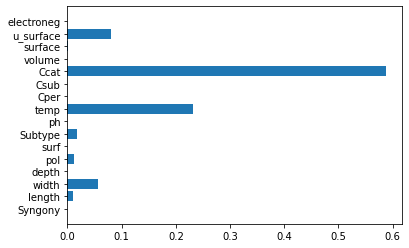

In [364]:
# Какие данные самые важные для этой модели

plt.barh(x.columns, dtr.feature_importances_)
plt.show()

In [370]:
# План предсказания входящих данных таков:
# Сначала предсказываем Kcat (это неплохо получается)
# Потом с помощью простой формулы получаем Vmax
# Затем уже предсказываем с помощью всех этих
# параметров Km

In [128]:
# Ищем самую эффективную модель для 
# предсказания Km
winner = get_winner(['Km'], 'Km')

SHUFFLING: 0
Learning rate set to 0.031226
0:	learn: 0.1017450	total: 829us	remaining: 829ms
1:	learn: 0.1013133	total: 1.64ms	remaining: 820ms
2:	learn: 0.1008595	total: 2.54ms	remaining: 843ms
3:	learn: 0.1004047	total: 3.27ms	remaining: 815ms
4:	learn: 0.0999964	total: 4.08ms	remaining: 812ms
5:	learn: 0.0995445	total: 4.85ms	remaining: 803ms
6:	learn: 0.0990587	total: 5.6ms	remaining: 795ms
7:	learn: 0.0986186	total: 6.46ms	remaining: 801ms
8:	learn: 0.0982180	total: 7.38ms	remaining: 812ms
9:	learn: 0.0978147	total: 8.28ms	remaining: 820ms
10:	learn: 0.0974198	total: 9.12ms	remaining: 820ms
11:	learn: 0.0970151	total: 9.88ms	remaining: 814ms
12:	learn: 0.0966362	total: 10.3ms	remaining: 780ms
13:	learn: 0.0962398	total: 11ms	remaining: 776ms
14:	learn: 0.0958759	total: 12ms	remaining: 787ms
15:	learn: 0.0954198	total: 13ms	remaining: 797ms
16:	learn: 0.0950713	total: 13.7ms	remaining: 795ms
17:	learn: 0.0946352	total: 14.5ms	remaining: 789ms
18:	learn: 0.0940528	total: 15.2ms	rema

In [331]:
winner

sklearn.linear_model._stochastic_gradient.SGDRegressor

In [189]:
# Делим данные и тестируем рекомендованную модель
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [186]:
sgd = SGDRegressor().fit(x_train, y_train)
sgd.score(x_train, y_train)

0.0149452061502503

In [366]:
# Похоже, что все модели вообще плохо справляются с этой
# целевой переменной. Попробуем напоследок подкрутить параметры:

In [179]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(SGDRegressor(), {
    'alpha': [1e-4, 1e-3, 5e-2, 5e-1, 1e-1],
    'l1_ratio': [0.15, 0.1, 0.05, 0.2, 0.3]
}, cv=5)

In [180]:
search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(),
             param_grid={'alpha': [0.0001, 0.001, 0.05, 0.5, 0.1],
                         'l1_ratio': [0.15, 0.1, 0.05, 0.2, 0.3]})

In [181]:
search.score(x_test, y_test)

-0.6128949470800178

In [367]:
# Плохой результат. Тогда попробуем концепцию предсказанияъ
# методом поиска самого похожего случая из датасета:

In [373]:
from sklearn.decomposition import PCA

# Сжимаем данные

x, y = scaled.drop(['Km'], axis=1), scaled['Km']
x_ = PCA(n_components=5).fit_transform(x)
y_ = y.values

In [116]:
s = []

# Тестируем способ

for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(
        x_, y_, test_size=0.2
    )
    
    def get_closest_idx(target):
        closest = None
        for i, row in enumerate(x_train):
            err = np.abs(row - target).sum()
            if closest is None or err < closest[1]:
                closest = (i, err)
        return closest[0]

    def closest_predict(target):
        idx = get_closest_idx(target)
        return y_train[idx]

    pred = []

    for row in x_test:
        pred.append(
            closest_predict(row)
        )

    pred = np.array(pred)
    score = np.abs(pred - y_test).mean()
    s.append(score)

In [117]:
s = pd.Series(s)
s.describe()

count    100.000000
mean       0.028716
std        0.014692
min        0.002498
25%        0.016843
50%        0.025700
75%        0.038268
max        0.071935
dtype: float64

In [118]:
err = scalers['Km'].inverse_transform(s.values.reshape(-1, 1))
np.median(err)

32.382691739130436

In [369]:
# Не очень хороший результат, учитывая то, что для данной
# целевой переменной ошибка 32 -- это очень много.

In [332]:
# Пробуем эту же концепцию, только с помощью модели

from sklearn.neighbors import KNeighborsRegressor

max_rs = maximize_test(KNeighborsRegressor(), x, y, num_iter=50)

In [333]:
# Очень даже неплохо, по сравнению с другими моделями

max_rs

(0.6147009025636787, KNeighborsRegressor())

In [335]:
# Подбираем параметры

max_result = None

for kn in range(3, 17):
    estimator = KNeighborsRegressor(n_neighbors=kn)
    max_rs = maximize_test(estimator, x, y, num_iter=50)
    if max_result is None or max_result[0] < max_rs[0]:
        max_result = max_rs

max_result

(0.6620573600101708, KNeighborsRegressor(n_neighbors=4))

In [336]:
# Готово. К сожалению, у данной
# модели нет feature importance.
kn = max_result[1]

In [374]:
# Не слишком хороший результат
kn.score(x, y)

0.3617622564071823